# Pose estimation benchmark notebook

Benchmarking completion time and confidence values of keypoint predictions

## 1. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import time
import random

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

import imageio
from IPython.display import HTML, display

2022-12-16 10:51:07.624595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 10:51:07.955897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karstu/GIT/ai_and_web_applications_project/.venv/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-12-16 10:51:07.955936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 10:51:08.049

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append(os.path.join("..", "modules"))

import file_utils
import model_utils
import tensor_utils
import visualisation_utils
import benchmark_utils

## 2. Benchmark

Run benchmark or open pickled result dataframe

In [3]:
load_benchmark_df_from_disk = False
result_df_filename = "benchmark_dataframe.pkl"

save_result_df_to_disk = True
amount_of_sample_images_to_save = 5
images_folder = os.path.join(os.getcwd(), "..", "..",
                           "pose_estimation_benchmark_images")
extensions = ('.png', '.jpg', '.jpeg')
image_limit = 250
annotations_file_path = os.path.join(images_folder, "mpii_val.json")


model_names = [
    "blazepose",
    "tflite_movenet_lightning_f16",
    "tflite_movenet_thunder_f16",
    "tflite_movenet_lightning_int8",
    "tflite_movenet_thunder_int8",
    "movenet_lightning",
    "movenet_thunder"
]

if load_benchmark_df_from_disk:
    df = benchmark_utils.open_dataframe_from_disk(result_df_filename)
else:
    df, samples = benchmark_utils.run_benchmark(
        model_names = model_names,
        images_folder = images_folder,
        image_limit = image_limit,
        save_result_df_to_disk = save_result_df_to_disk,
        result_df_filename = result_df_filename,
        amount_of_sample_images_to_save = amount_of_sample_images_to_save,
        annotations_file_path = annotations_file_path
    )

Running benchmark

Using model 1/7 - 'blazepose'


2022-12-16 10:51:13.672667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karstu/GIT/ai_and_web_applications_project/.venv/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-12-16 10:51:13.672729: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-16 10:51:13.672768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DKAJLT144): /proc/driver/nvidia/version does not exist
2022-12-16 10:51:13.673352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in p

- Done                        
Using model 2/7 - 'tflite_movenet_lightning_f16'
- Model 'tflite_movenet_lightning_f16.tflite' found.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


- Done                        
Using model 3/7 - 'tflite_movenet_thunder_f16'
- Model 'tflite_movenet_thunder_f16.tflite' found.
- Done                        
Using model 4/7 - 'tflite_movenet_lightning_int8'
- Model 'tflite_movenet_lightning_int8.tflite' found.
- Done                        
Using model 5/7 - 'tflite_movenet_thunder_int8'
- Model 'tflite_movenet_thunder_int8.tflite' found.
- Done                        
Using model 6/7 - 'movenet_lightning'
- Done                        
Using model 7/7 - 'movenet_thunder'
- Done                        
Benchmark finished. Evaluated 7 models with 250 images.
Saved sampling data from 35 images.
Saving created dataframe to disk: '/home/karstu/GIT/ai_and_web_applications_project/modules/../benchmark_dataframes/benchmark_dataframe.pkl'


## 3. Analyzing results

### 3.1. Basics

In [4]:
df.sample(5)

model name  completion time     image name  accuracy  \
1581             movenet_thunder         0.048829  030667397.jpg  0.994912   
682   tflite_movenet_thunder_f16         0.065954  042690209.jpg  0.991168   
180                    blazepose         0.251706  000735304.jpg  0.910019   
1702             movenet_thunder         0.046535  076858133.jpg  0.967675   
1371           movenet_lightning         0.024034  086387015.jpg  0.881028   

          nose  left_eye  right_eye  left_ear  right_ear  left_shoulder  ...  \
1581  0.561486  0.552091   0.557279  0.508829   0.657298       0.426748  ...   
682   0.452871  0.382836   0.496419  0.598857   0.482264       0.609282  ...   
180   0.999821  0.999622   0.999850  0.999423   0.999454       0.998106  ...   
1702  0.393935  0.326775   0.319394  0.339893   0.496556       0.409797  ...   
1371  0.275019  0.314170   0.275050  0.459780   0.400609       0.493672  ...   

      left_elbow  right_elbow  left_wrist  right_wrist  left_hip  right_hip  \
1581    0.616050     0.545347    0.334668     0.279582  0.623525   0.582542   
682     0.629746     0.234444    0.461077     0.566023  0.589081   0.643063   
180     0.043817     0.826351    0.130155     0.875705  0.998845   0.999286   
1702    0.217952     0.337080    0.433485     0.542051  0.662127   0.374565   
1371    0.209798     0.277732    0.303953     0.624025  0.451901   0.436366   

      left_knee  right_knee  left_ankle  right_ankle  
1581   0.460672    0.318331    0.663961     0.498610  
682    0.150387    0.172440    0.010637     0.141930  
180    0.017879    0.142708    0.019420     0.100820  
1702   0.442447    0.295807    0.571566     0.218680  
1371   0.094165    0.114745    0.105239     0.622773  

[5 rows x 21 columns]

In [5]:
df.describe()

completion time     accuracy         nose     left_eye    right_eye  \
count      1750.000000  1750.000000  1750.000000  1750.000000  1750.000000   
mean          0.082376     0.894849     0.524368     0.532369     0.525463   
std           0.081259     0.158668     0.234518     0.238836     0.240528   
min           0.015272     0.000000     0.000000     0.000000     0.000000   
25%           0.027653     0.847737     0.373317     0.373317     0.373317   
50%           0.049957     0.971588     0.499816     0.501770     0.499816   
75%           0.112275     0.985869     0.626208     0.635012     0.629697   
max           0.433700     0.997170     1.000000     1.000000     1.000000   

          left_ear    right_ear  left_shoulder  right_shoulder   left_elbow  \
count  1750.000000  1750.000000    1750.000000     1750.000000  1750.000000   
mean      0.523933     0.523860       0.563504        0.555193     0.431037   
std       0.242623     0.242558       0.245798        0.246976     0.242247   
min       0.000000     0.000000       0.000000        0.000000     0.000000   
25%       0.364620     0.366292       0.382921        0.375083     0.264934   
50%       0.486775     0.499816       0.518377        0.507153     0.373317   
75%       0.635012     0.635012       0.734591        0.719869     0.562822   
max       1.000000     1.000000       1.000000        1.000000     0.999999   

       right_elbow   left_wrist  right_wrist     left_hip    right_hip  \
count  1750.000000  1750.000000  1750.000000  1750.000000  1750.000000   
mean      0.426410     0.388272     0.392252     0.537004     0.532061   
std       0.239173     0.239073     0.244515     0.246546     0.244384   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.264934     0.214912     0.217767     0.373317     0.368671   
50%       0.373317     0.345741     0.344589     0.501770     0.501543   
75%       0.559916     0.501770     0.501770     0.661592     0.647595   
max       0.999860     1.000000     0.999943     1.000000     1.000000   

         left_knee   right_knee   left_ankle  right_ankle  
count  1750.000000  1750.000000  1750.000000  1750.000000  
mean      0.371324     0.367672     0.326683     0.325990  
std       0.225178     0.233988     0.241153     0.237912  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.207385     0.192770     0.122906     0.139795  
50%       0.364620     0.351912     0.299070     0.295961  
75%       0.499816     0.499696     0.455555     0.445209  
max       1.000000     1.000000     0.999997     0.999514

### 3.2 Average completion times and confidence values for each model

In [6]:
averages = df.groupby('model name').mean().reset_index()
averages

model name  completion time  accuracy      nose  \
0                      blazepose         0.261075  0.822504  0.903220   
1              movenet_lightning         0.027424  0.905753  0.449089   
2                movenet_thunder         0.052367  0.902972  0.471246   
3   tflite_movenet_lightning_f16         0.017840  0.905642  0.446881   
4  tflite_movenet_lightning_int8         0.038119  0.910731  0.441395   
5     tflite_movenet_thunder_f16         0.064061  0.903016  0.472115   
6    tflite_movenet_thunder_int8         0.115743  0.913327  0.486628   

   left_eye  right_eye  left_ear  right_ear  left_shoulder  right_shoulder  \
0  0.902551   0.903192  0.903095   0.902468       0.903853        0.903862   
1  0.453171   0.435618  0.449732   0.447275       0.476625        0.478225   
2  0.493446   0.481179  0.492196   0.487108       0.546708        0.528275   
3  0.454547   0.435096  0.450565   0.447829       0.476271        0.479912   
4  0.473662   0.480725  0.416322   0.438986       0.451146        0.435692   
5  0.491831   0.482571  0.491986   0.488055       0.548322        0.530454   
6  0.457373   0.459862  0.463635   0.455302       0.541606        0.529933   

   left_elbow  right_elbow  left_wrist  right_wrist  left_hip  right_hip  \
0    0.659436     0.611785    0.638232     0.643741  0.900083   0.901012   
1    0.365139     0.365204    0.319538     0.321586  0.449042   0.448209   
2    0.406556     0.421778    0.359379     0.360661  0.512646   0.502258   
3    0.365108     0.363807    0.321066     0.319533  0.449506   0.449272   
4    0.399509     0.385072    0.351313     0.345938  0.454718   0.436839   
5    0.405513     0.419383    0.358722     0.361428  0.511460   0.501667   
6    0.415995     0.417842    0.369656     0.392874  0.481570   0.485167   

   left_knee  right_knee  left_ankle  right_ankle  
0   0.478381    0.512480    0.471141     0.482216  
1   0.337233    0.331370    0.298962     0.279810  
2   0.358518    0.348523    0.301187     0.316113  
3   0.336601    0.331516    0.298779     0.278879  
4   0.357180    0.343185    0.320833     0.302561  
5   0.360896    0.349464    0.300372     0.315217  
6   0.370459    0.357164    0.295506     0.307131

### 3.3 Lowest average completion time

In [7]:
averages[averages["completion time"] == averages['completion time'].min()]

model name  completion time  accuracy      nose  \
3  tflite_movenet_lightning_f16          0.01784  0.905642  0.446881   

   left_eye  right_eye  left_ear  right_ear  left_shoulder  right_shoulder  \
3  0.454547   0.435096  0.450565   0.447829       0.476271        0.479912   

   left_elbow  right_elbow  left_wrist  right_wrist  left_hip  right_hip  \
3    0.365108     0.363807    0.321066     0.319533  0.449506   0.449272   

   left_knee  right_knee  left_ankle  right_ankle  
3   0.336601    0.331516    0.298779     0.278879

### 3.4 Visualize completion times per model

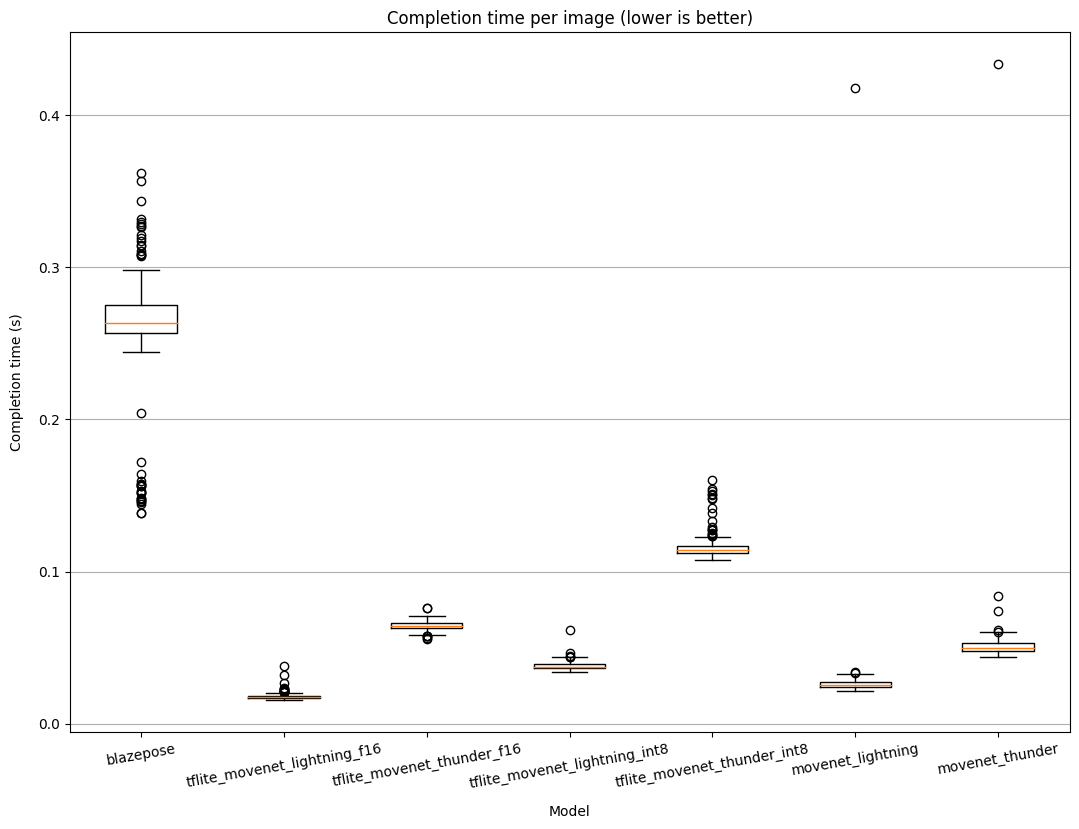

In [8]:
visualisation_utils.visualize_box_plot(
    df = df,
    grouping = "model name",
    to_plot = "completion time",
    x_label = "Model",
    y_label = "Completion time (s)",
    title = "Completion time per image (lower is better)"
)

### 3.5 Visualize average confidence values

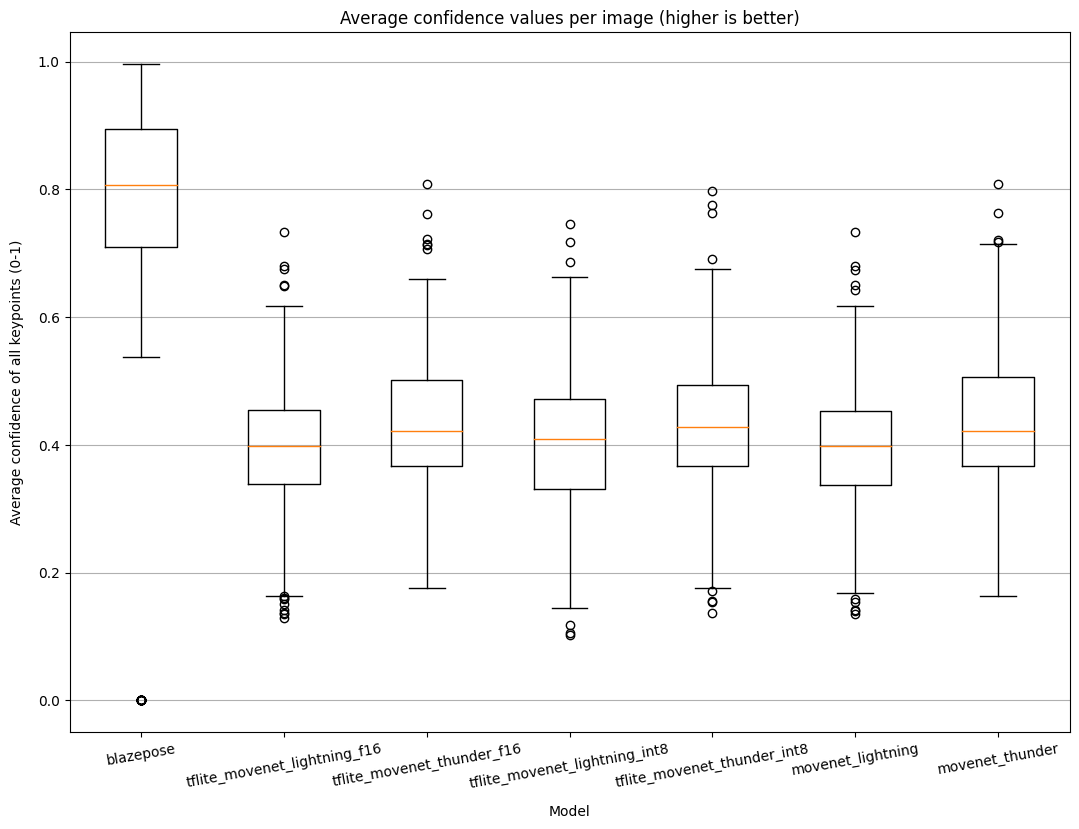

In [9]:
confidences = list(visualisation_utils.KEYPOINT_DICT.keys())
df['average confidence'] = df.apply(lambda row: row[confidences].mean(), axis = 1)


visualisation_utils.visualize_box_plot(
    df = df,
    grouping = "model name",
    to_plot = "average confidence",
    x_label = "Model",
    y_label = "Average confidence of all keypoints (0-1)",
    title = "Average confidence values per image (higher is better)"
)

### 3.6 Visualize accuracies

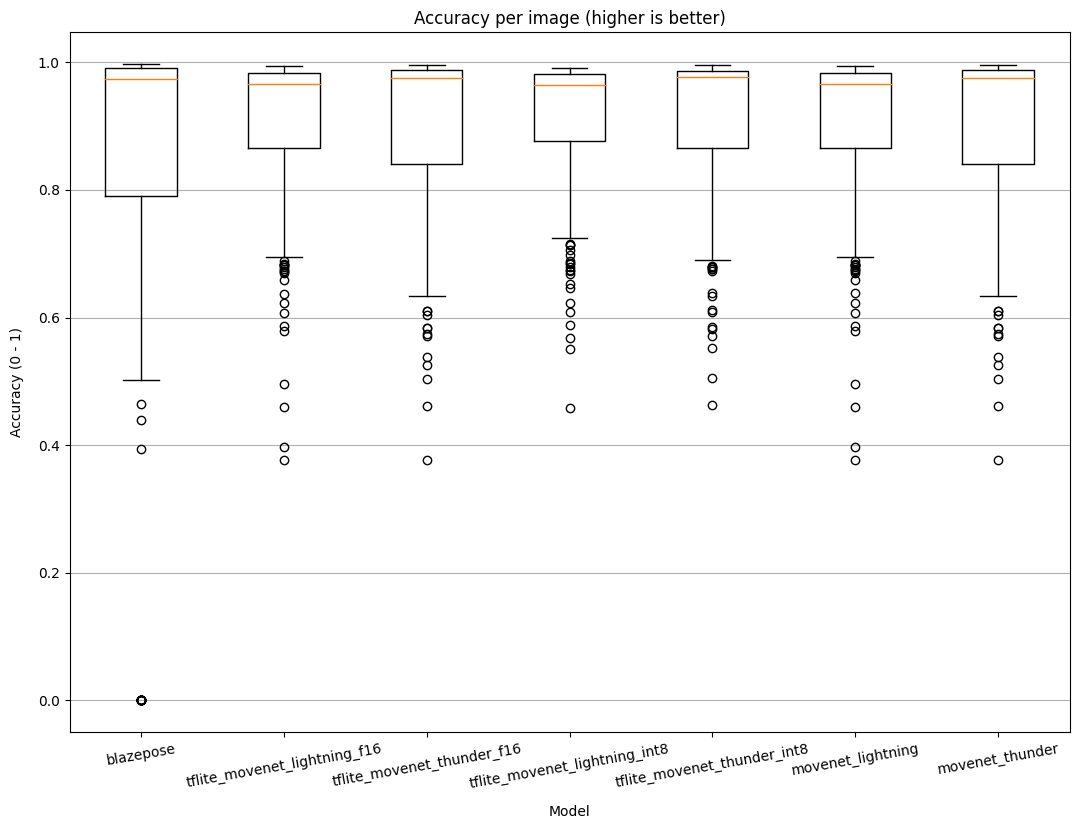

In [10]:
visualisation_utils.visualize_box_plot(
    df = df,
    grouping = "model name",
    to_plot = "accuracy",
    x_label = "Model",
    y_label = "Accuracy (0 - 1)",
    title = "Accuracy per image (higher is better)"
)

### 3.7 Best average accuracy

In [11]:
averages[averages["accuracy"] == averages['accuracy'].max()]

model name  completion time  accuracy      nose  left_eye  \
6  tflite_movenet_thunder_int8         0.115743  0.913327  0.486628  0.457373   

   right_eye  left_ear  right_ear  left_shoulder  right_shoulder  left_elbow  \
6   0.459862  0.463635   0.455302       0.541606        0.529933    0.415995   

   right_elbow  left_wrist  right_wrist  left_hip  right_hip  left_knee  \
6     0.417842    0.369656     0.392874   0.48157   0.485167   0.370459   

   right_knee  left_ankle  right_ankle  
6    0.357164    0.295506     0.307131

### 3.8 Visualize difference in keypoints

Visualizing the differences requires that the benchmark has been run.

Creating 7 x 5 visualization collage
- Composing...                


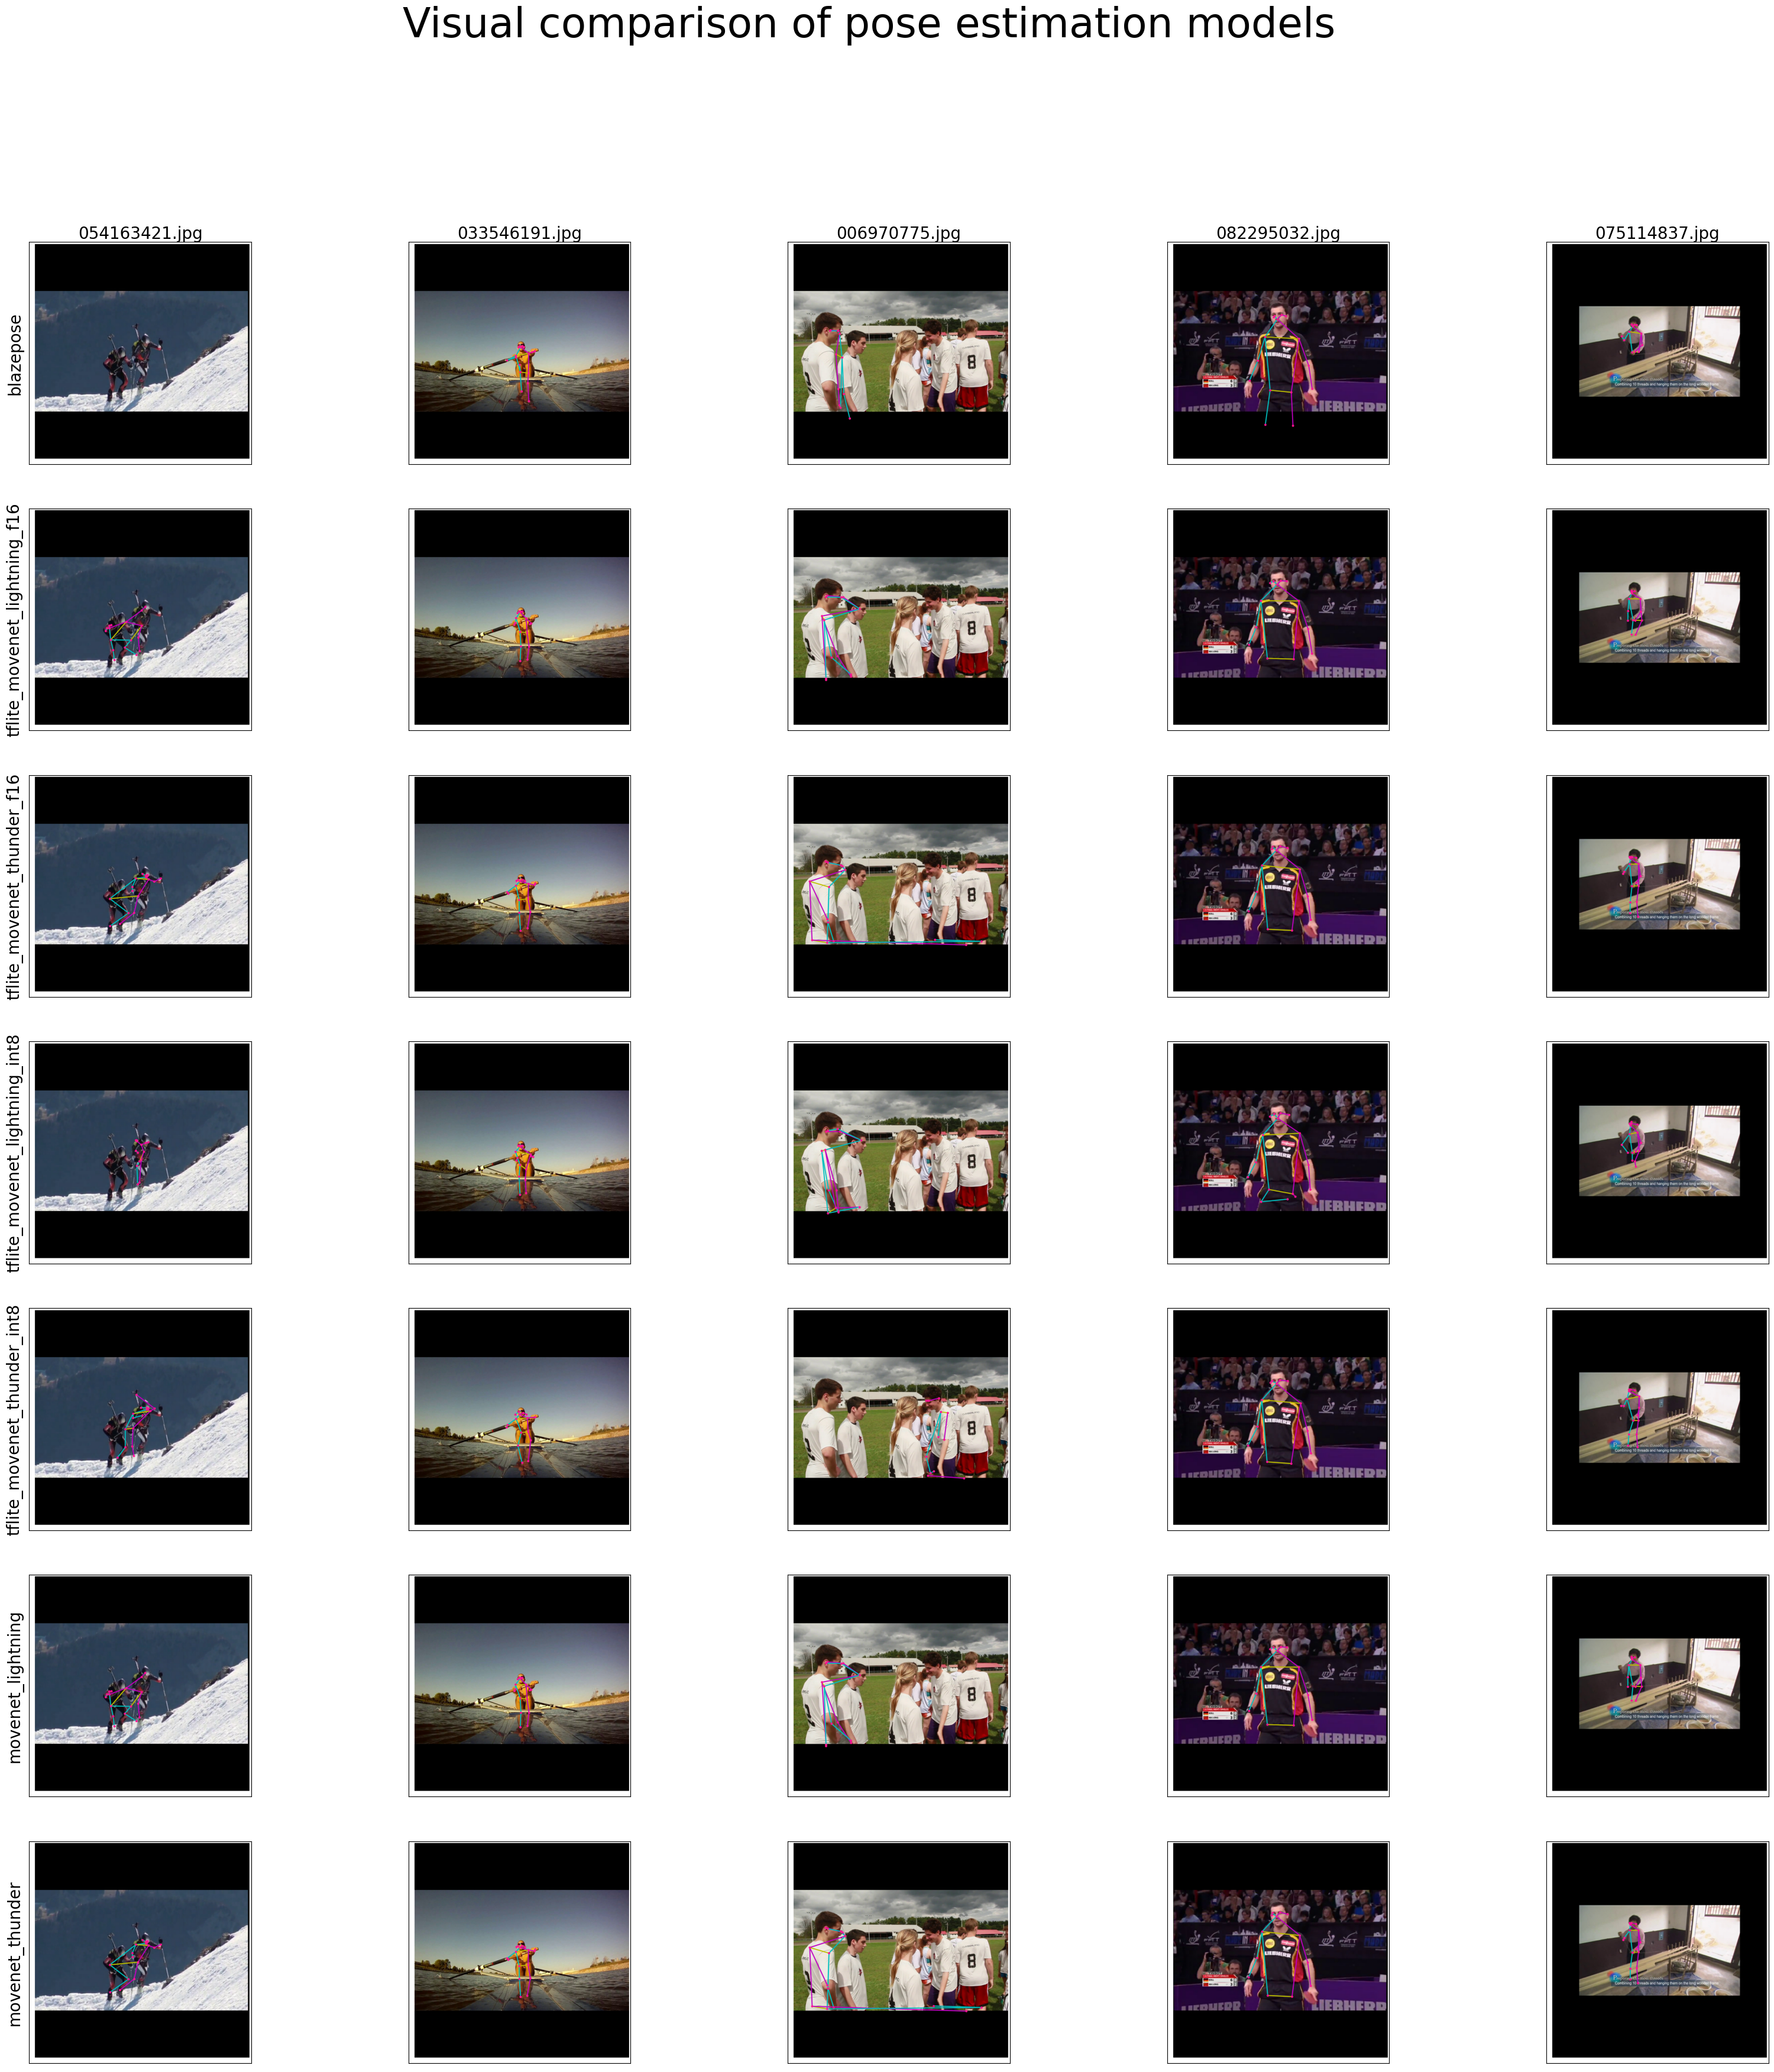

In [12]:
if not load_benchmark_df_from_disk:
    visualisation_utils.visualize_multiple_images(samples, model_names)